# Problem Set 2
## Due Sunday May 5, 2019 @ 11:59pm


## Lino Valdovino, SID:861300001


In this problem set, you will implement logistic regression and cross-validation for classifying spam.
You may *not* use scikit-learn or similar libraries, but only the linear algebra libraries of numpy.
To that end, the code block below is the only "imports" you may have.  This block also loads the data.


In [131]:

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

%matplotlib inline
import warnings
plt.rcParams["figure.figsize"] = (16, 9) # (w, h)
warnings.filterwarnings('ignore')


trainX = np.loadtxt('spamtrainX.data')
trainY = np.loadtxt('spamtrainY.data')[:,np.newaxis]
testX = np.loadtxt('spamtestX.data')
testY = np.loadtxt('spamtestY.data')[:,np.newaxis]

## Part a: (2 points)

Y is encoded as +1/-1.  X is encoded as a vector of features, including the relative frequency of different words, character, and the like.  You can read more at http://archive.ics.uci.edu/ml/datasets/Spambase

First construct a "feature function" that will take the given features and construct additional features.  In particular, it should add a (first) column of "all ones" so that the corresponding weight is the intercept term. Additionally, it should (optionally, depending on the boolean `addbool` parameter) add one extra feature for each regular input that is 1 if the input is positive and 0 if the input is non-positive.  Because the raw features in this dataset are frequencies, we might like to add extra Boolean features to represent whether the item is present, regardless of how frequently.

For instance, the code below should output

    [[3 0 1]
     [0 2 2]]
    [[1. 3. 0. 1.]
     [1. 0. 2. 2.]]
    [[1. 3. 0. 1. 1. 0. 1.]
     [1. 0. 2. 2. 0. 1. 1.]]

<font color=red>__To Do: Implement function `phi`, below__</font>

In [132]:

def phi(X,addbool):
    # adds initial column of ones
    # if quad is True, also adds (at the end) all second-order combinations of features
    # returns the resulting matrix 
    if addbool:
        b = (X > 0)
        X0 = np.ones(len(X))
        X =  np.column_stack((X0 , X, b))
        return X; 
    else:
        X0 = np.ones(len(X))
        X =  np.column_stack((X0 , X))
        return X; 
    
    

                                                
# print(len(trainX))   
X = np.array([[3,0,1],[0,2,2]])
print (X)
print (phi(X,False))
print (phi(X,True))

[[3 0 1]
 [0 2 2]]
[[1. 3. 0. 1.]
 [1. 0. 2. 2.]]
[[1. 3. 0. 1. 1. 0. 1.]
 [1. 0. 2. 2. 0. 1. 1.]]


## Part b (8 points)

Write the three functions below that evaluate the loss, gradient of the loss, and Hessian of the loss for logistic regression.

While the slides from class show this for the *un*regularized version, for this assignment, we will be using L2 regularization.  Thus, the full loss function is
\begin{align*}
L &= \left[\sum_{i=1}^m \ln(1+e^{-y_ix_i^\top w})\right] + \frac{\lambda}{2}\sum_{j=2}^n w_j^2
\end{align*}
Note that this regularization does *not* penalize the first weight, the weight that corresponds to the intercept term.

<font color=red>__To Do: (1) Write the equations in the next cell, and (2) Write the code to implement them in the subsequent cell__</font>

Write the equations for the gradient and Hessian with this new regularized loss function here.  Feel free to define extra notation if that makes things simpler.

$$Definitions$$
$$ pi = p(y_i|x_i) = \sigma(y_ix_i^Tw)     $$

$$ln(\sigma(a)) = ln\left(\frac {1}{1+e^{-a}}\right) = ln(1) - ln(1+e^{-a}) =  - ln(1+e^{-a}) \; \; $$

$$\sigma(a)' = \sigma(a)(1-\sigma(a))$$

$$Loss$$

\begin{align*}
L &= \sum_{i=1}^m -\ln(pi) + \frac{\lambda}{2}\sum_{j=2}^n w_j^2
\end{align*}

$$Gradient$$

$$\nabla_w L = \sum_{i=1}^m\nabla_w \left(-\ln(pi) + \frac{\lambda}{2}\sum_{j=2}^n w_j^2 \right)=  \sum_{i=1}^m-(1-pi)y_ix_i^T + {\lambda}w  $$

$$\nabla_w L = X^Tt + m \lambda w, \;\;\;\; t_i = (1-pi)yi, \;\; t = (1-P)Y, \;\; P\; is\; m*1$$

$$Hessian$$

$$\frac{\partial2L}{\partial w^2} = \sum_{i=1}^m\nabla_w \left(-(1-p_i)y_ix_i^T + {\lambda}\sum_{j=2}^nw_j \right)=  \sum_{i=1}^m pi(1-p_i)y_iy_ix_ix_i^T+ {\lambda}I= \sum_{i=1}^m pi(1-p_i)x_ix_i^T+ {\lambda}I,   \;\;\;\; y_iy_i = 1$$

$$\frac{\partial2L}{\partial w^2} = X^TRX + m \lambda I, \;\;\;\; R_{ii}=pi(1-pi), \;\; R=P-P P^T, \;\; P\; is\; m*m$$

Notice that $w[0]$ does not get penelized, so $w[0]$ does not get taken into consideration in the Gradient and in the Hessian 

In [226]:
def lrloss(w,X,Y,lmbda):
    tloss = np.log(1 + np.exp(-1*Y*X@w)) + lmbda/2*np.sum(w[1:]**2) 
    return np.sum(tloss)


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def lrgrad(w,X,Y,lmbda):
    g = 0
    for i in range(len(Y)):
        pi = sigmoid(Y[i]*np.array([X[i]])@w)
        w_n = np.copy(w)
        w_n[0] = 0;
#         print(lmbda*w_n)
        g+= -1*(1-pi)*Y[i]*np.array([X[i]]).T + lmbda*w_n
    return g

def lrhess(w,X,Y,lmbda):
    h=0
    for i in range(len(Y)):
        pi = sigmoid(Y[i]*np.array([X[i]])@w)
#         print(pi)
        #notice the result is a n*n matrix 
        LI = lmbda*np.identity(X.shape[1])
        LI[0][0] = 0
        h += pi*(1-pi)*np.array([X[i]]).T@np.array([X[i]]) + LI
    return h  

#optimize version 
def lrgrad1(w,X,Y,lmbda): 
    P = sigmoid(Y*X@w)
    w_n = np.copy(w)
    w_n[0] = 0;
    t = (1-P)*Y
    return -1*X.T@t + X.shape[0]*lmbda*w_n

def lrhess1(w,X,Y,lmbda):
    P = sigmoid(Y*X@w)
    P = np.diagflat(np.matrix(P))
    R = P - P@P.T
    LI = lmbda*np.identity(X.shape[1])
    LI[0][0] = 0
    h = X.T@R@X + X.shape[0]*LI
    return h


#test functions 
X = phi(trainX,False)  #add new features 
w = np.zeros(X.shape[1]).reshape(X.shape[1],1)
# w = np.random.uniform(-.05,.05,X.shape[1]).reshape(X.shape[1],1)
# print(trainY)
#Y = np.diagflat(np.matrix(trainY))
print(lrloss(w = w,X = X ,Y=trainY ,lmbda = .01))
# a = lrgrad(w = w,X = X ,Y=trainY ,lmbda = .01)
a1 = lrgrad1(w = w,X = X ,Y=trainY ,lmbda = .01)
# b =lrhess(w = w,X = X ,Y=trainY ,lmbda = .01)
b1 =lrhess1(w = w,X = X ,Y=trainY ,lmbda = .01)
# print(a.T)
# print(a1.T)
# print(b)
# print(b1)
c = np.linalg.solve(b1, a1)
# print(c.shape)
# w = w - .00000001*a #Grad step 
w = w - c  #newton step
print('newton step')
print(lrloss(w = w,X = X ,Y=trainY ,lmbda = .01))

2079.441541679836
newton step
1125.219808223373


## Part c (8 points)

Now write the below function to perform Newton-Raphson minimization.  Do not worry about the data or other ML aspects.  Instead, just focus on writing code to optimize a function.

Newton's method is relatively straight-forward, except when it doesn't work.

For that reason, you need to check the value of the function after each iteration.  If it has gone *up* (ie, the wrong way) or stayed the same, you need to resort to moving in the direction of the negative gradient.  Keep a step size (and start it at 1.0).  Each time a second-order Newton step fails, double the step size and try taking a gradient step.  If it also fails (ie does not improve the function), half the step size and try again.  Keep halving the step size until the step size is less then $10^{-10}$.  As soon as a step succeeds, return to second-order Newton steps.  If no step size succeeds, you are done (and probably at a minimum).

<font color=red>__To Do: Implement function `newton`, and read the subsequent cells' code to understand how it comes together__</font>

In [228]:
# You should implement "newton" below
# However, as an example, here is gradient descent implemented with a constant step size
# (note: this is *not* a good implementation, but just to show the idea)
# The "ittfn" can help with debugging, but isn't necessary
def graddesc(w,eta,fn,gradfn,ittfn=None):
    oldf = fn(w)
    #print(oldf)
    df = 1
    while(df>1e-6):
        w = w - eta*gradfn(w)
        newf = fn(w)
        #print(newf)
        df = oldf-newf # hope to be positive, or we've over-shot and will be done
        if ittfn is not None:
            ittfn(w,eta,newf)
        oldf = newf
    return w
    
# Newton Ra
# note, to find A^{-1}*b, use np.linalg.solve(A,b)
def newton(w,fn,gradfn,hessfn,ittfn=None):
    grad = True
    step = .5
    oldf = fn(w)
    wOld = np.copy(w)
    while( step > 1e-9 ):
        #print("Hess step")
        wOld = np.copy(w)
        w = w - np.linalg.solve(hessfn(w), gradfn(w)) 
        newf = fn(w)
        #print(newf)
        df = oldf-newf
        if(df <= 0): # hess step fails  take grad step 
            grad = True
            step *= 2  
            while(grad):
                #print("step: " +str(step))
                w = np.copy(wOld)
                #print("Grad step")
                w = w - step*gradfn(w)
                newf = fn(w)
                #print(newf)
                df = oldf-newf 
                if(df > 0):
                    grad = False
                else:
                    step /= 2  #half the step size and try again
                if(step < 1e-10 ):  #if grad ste fails then local minimun 
                    #print("Step size limit")
                    #print("final loss")
                    #newf = fn(wOld)
                    #print(newf)
                    return wOld
        oldf = newf
    return w

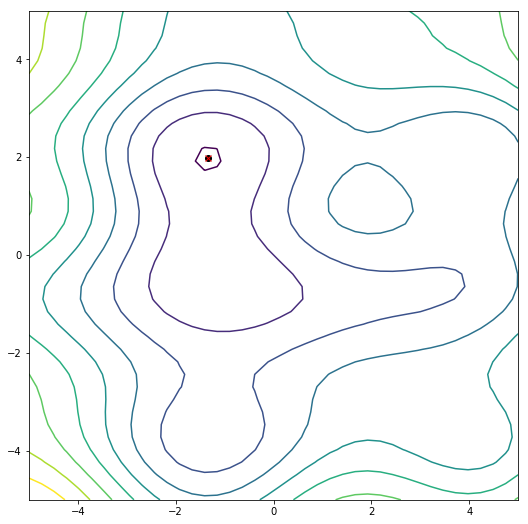

In [229]:
# here is an example of using the optimization routines above
# (you don't need to do anything here, just example code of how newton, above, could be used)
# try moving the stating point (x0) around to see the effects, if you are curious

def myf(x): # a simple 2d function
    return 0.25*np.sum(x*x,0) + 2*np.sin(x[0,:]) + np.sin(2*x[1,:]) + np.sin(x[0,:])*np.sin(x[1,:])

def mygrad(x):
    a = x[0,0]
    b = x[1,0]
    return np.array([[0.5*a + 2*np.cos(a) + np.cos(a)*np.sin(b),
                      0.5*b + 2*np.cos(2*b) + np.sin(a)*np.cos(b)]]).T

def myhess(x):
    a = x[0,0]
    b = x[1,0]
    return np.array([[0.5-2*np.sin(a)-np.sin(a)*np.sin(b), np.cos(a)*np.cos(b)],
                   [np.cos(a)*np.cos(b), 0.5-4*np.sin(2*b)-np.sin(a)*np.sin(b)]])

xs1 = np.linspace(-5,5,40)
ys1 = np.linspace(-5,5,40)
xs,ys = np.meshgrid(xs1,ys1)
pts = np.hstack((xs.reshape((1600,1)),ys.reshape((1600,1))))
vals = myf(pts.T).T
plt.contour(xs,ys,vals.reshape((40,40)),10)
plt.axis('square')

x0 = np.array([[-1.0,2.0]]).T
xmin = graddesc(x0,0.1,myf,mygrad)
plt.plot(xmin[0,0],xmin[1,0],'ko')
xmin = newton(x0,myf,mygrad,myhess)
_=plt.plot(xmin[0,0],xmin[1,0],'rx')

In [223]:
# You should now be able to train logistic regression on the spam dataset.  
# You just need to use anonymous functions to get the data into the loss, gradient, and Hessian functions.
# Below shows how

def trainlr(X,Y,lmbda):
    w0 = np.zeros((X.shape[1],1)) # starting w at zero works well for LR
    return newton(w0,lambda w : lrloss(w,X,Y,lmbda),
                  lambda w : lrgrad1(w,X,Y,lmbda),
                  lambda w : lrhess1(w,X,Y,lmbda))

def trainlr2(X,Y,lmbda):
    w0 = np.zeros((X.shape[1],1)) # starting w at zero works well for LR
    return graddesc(w0,lmbda,
                  lambda w : lrloss(w,X,Y,lmbda),
                  lambda w : lrgrad(w,X,Y,lmbda))

def lrerrorrate(X,Y,w):
    return np.sum(Y*X@w<0)/Y.shape[0]

# lmbda = 0.06309573444801936
lmbda = .001
useextrafeatures = True
mytrainX = phi(trainX,useextrafeatures)
mytestX = phi(testX,useextrafeatures)
myw = trainlr(mytrainX,trainY,lmbda)
print (myw.T.shape)
print (lrerrorrate(mytestX,testY,myw))

Hess step
836.4644642860402
Hess step
616.4558509023814
Hess step
543.7059537090977
Hess step
518.0186743649954
Hess step
505.5061261772547
Hess step
501.95173376319076
Hess step
501.1514894799971
Hess step
500.85626214963526
Hess step
500.8548014073944
Hess step
500.8548013396644
Hess step
500.85480133966433
Hess step
500.8548013396644
step: 0.5
Grad step
500.8548013396644
step: 0.25
Grad step
500.8548013396644
step: 0.125
Grad step
500.8548013396644
step: 0.0625
Grad step
500.85480133966433
step: 0.03125
Grad step
500.8548013396644
step: 0.015625
Grad step
500.8548013396644
step: 0.0078125
Grad step
500.85480133966433
step: 0.00390625
Grad step
500.85480133966433
step: 0.001953125
Grad step
500.85480133966433
step: 0.0009765625
Grad step
500.85480133966433
step: 0.00048828125
Grad step
500.8548013396644
step: 0.000244140625
Grad step
500.8548013396644
step: 0.0001220703125
Grad step
500.8548013396644
step: 6.103515625e-05
Grad step
500.85480133966433
step: 3.0517578125e-05
Grad step


## Part d (6 points)

But how to decide whether to use the extra features or not?  How to decide whether what value of lambda is best?

Implement 3-fold cross validation and use it to plot the cross-validation error as a function of lambda, with and without the extra features (two different curves on the same plot).  I would recommend lambda values from $10^{-4}$ through $10^2$.

<font color=red>__To Do: (1) Implement code below to plot the graph, and (2) Answer the questions at the end__</font>

[1.00000000e-04 2.51188643e-04 6.30957344e-04 1.58489319e-03
 3.98107171e-03 1.00000000e-02 2.51188643e-02 6.30957344e-02
 1.58489319e-01 3.98107171e-01 1.00000000e+00 2.51188643e+00
 6.30957344e+00 1.58489319e+01 3.98107171e+01 1.00000000e+02]
Original features

Extra features


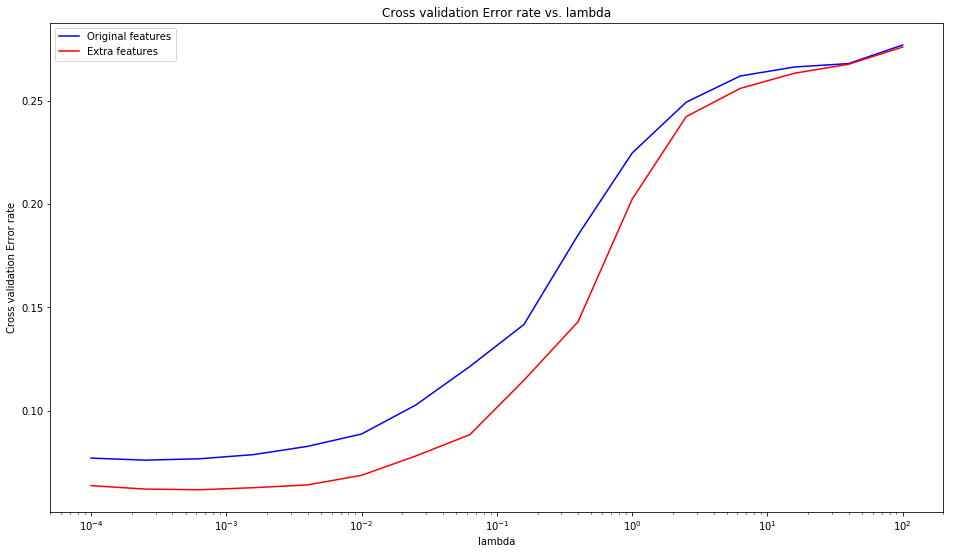

<Figure size 1440x1280 with 0 Axes>

In [201]:
num = 16
pts = np.logspace(-4, 2.0, num=num)
print(pts)

err1 = np.zeros(num)

print("Original features")
for i in range(len(pts)):
    lmbda = pts[i]
#     print("lambda: " +str(lmbda))
    useextrafeatures = False
    temp_err = 0.0
    mytrainX = phi(trainX,useextrafeatures)
    for j in range(3):
        vx = mytrainX[1000*j:1000*(j+1), ...] #validating X
        tx = np.delete(mytrainX,slice(1000*j, 1000*(j+1)), axis=0) #training X
        vy = trainY[1000*j:1000*(j+1), ...] #validating Y
        ty = np.delete(trainY,slice(1000*j, 1000*(j+1)), axis=0) #training Y
        myw = trainlr(tx,ty,lmbda)
        e = lrerrorrate(vx,vy,myw)
#         print('Validation Error: ' + str(j) + ' ' + str(e))
        temp_err += e
    temp_err /= 3 
#     print('Validation Average: ' + str(i) + ' ' + str(temp_err))
    err1[i] = temp_err
    

print("\nExtra features")  
err2 = np.zeros(num)
for i in range(len(pts)):
    lmbda = pts[i]
#     print("lambda: " +str(lmbda))
    useextrafeatures = True
    temp_err = 0.0
    mytrainX = phi(trainX,useextrafeatures)
    for j in range(3):
        vx = mytrainX[1000*j:1000*(j+1), ...] #validating X
        tx = np.delete(mytrainX,slice(1000*j, 1000*(j+1)), axis=0) #training X
        vy = trainY[1000*j:1000*(j+1), ...] #validating Y
        ty = np.delete(trainY,slice(1000*j, 1000*(j+1)), axis=0) #training Y
        myw = trainlr(tx,ty,lmbda)
        e = lrerrorrate(vx,vy,myw)
#         print('Validation Error: ' + str(j) + ' ' + str(e))
        temp_err += e
    temp_err /= 3 
#     print('Validation Average: ' + str(i) + ' ' + str(temp_err))
    err2[i] = temp_err


plt.semilogx(pts,err1 ,'b-')
plt.semilogx(pts,err2 ,'r-')

plt.title('Cross validation Error rate vs. lambda' )
plt.xlabel('lambda')
plt.ylabel('Cross validation Error rate')
# plt.xlim(.000001,.1)
plt.legend(("Original features","Extra features" ),loc='upper left')
    
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.show()


Based on this result, would you use the extra binary features?  What value of lambda would you select?

How well does this combination do on the *testing* data?

Using the extra features is good since in general they improve the results regardless of our choice of $\lambda$. However $\lambda$ is really important. If we penalize the weights too much by making $\lambda$ large then our accuracy falls, but if making too small then the benefits of using regularization diminish. I think based on the results from 3-fold cross-validation, any $\lambda$ in the range of $10^{-3}$ through $10^{-2}$ makes the best sence like .005. 